In [ ]:
# Load this cell for all the libraries and helper functions
import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms
import PIL

# Helper Functions
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def compute_accuracy(model, data_loader, device):
    with torch.no_grad():
        correct_pred, num_examples = 0, 0
        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.float().to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

def plot_accuracy(train_acc_list, valid_acc_list):
    train_acc_list = [acc.cpu().detach().numpy() if isinstance(acc, torch.Tensor) else acc for acc in train_acc_list]
    valid_acc_list = [acc.cpu().detach().numpy() if isinstance(acc, torch.Tensor) else acc for acc in valid_acc_list]

    num_epochs = len(train_acc_list)
    num_epochs = len(train_acc_list)

    plt.plot(np.arange(1, num_epochs+1),
             train_acc_list, label='Training')
    plt.plot(np.arange(1, num_epochs+1),
             valid_acc_list, label='Validation')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

# SETTINGS for Hyperparameters
RANDOM_SEED = 1
set_all_seeds(RANDOM_SEED)
SETTINGS = {'num epochs': 100,
            'lambda': 0.01,} # weight decay hyperparameter for L2 regularization

#**Logistic Regression Model**

In [ ]:
# Define transformation: resize, grayscale, and tensor conversion.
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Create train, val and test datasets
full_dataset = datasets.Caltech101(root='./data', download=True, transform=transform)

# we are going to use only these two classes
selected_classes = ['Faces', 'Faces_easy']
indices = [i for i, (img, label) in enumerate(full_dataset) if full_dataset.categories[label] in selected_classes]
subset = Subset(full_dataset, indices)
train_dataset, val_dataset, test_dataset = random_split(subset, [100, 500, 270])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Files already downloaded and verified


In [ ]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.fc1 = nn.Linear(input_size, 15)
        self.fc2 = nn.Linear(15, 45)
        self.fc3 = nn.Linear(45, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

In [ ]:
# Instantiate the model
input_size = 32 * 32 * 1  # Input size of the images
num_classes = 2  # Number of classes
model = LogisticRegression(input_size, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LogisticRegression(
  (fc1): Linear(in_features=1024, out_features=15, bias=True)
  (fc2): Linear(in_features=15, out_features=45, bias=True)
  (fc3): Linear(in_features=45, out_features=2, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)

In [ ]:
start_time = time.time()
minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []

for epoch in range(SETTINGS['num epochs']):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.to(device)
        targets = targets.to(device)

        # Forward pass
        logits = model(features)
        loss = F.cross_entropy(logits, targets)

        # Zero gradients, backprop, and update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        minibatch_loss_list.append(loss.item())
        if batch_idx % 50 == 0:
            print(f'Epoch: {epoch+1:03d}/{SETTINGS["num epochs"]:03d} '
                  f'| Batch {batch_idx:04d}/{len(train_loader):04d} '
                  f'| Loss: {loss.item():.4f}')

    # Evaluate on training and validation sets
    model.eval()
    with torch.no_grad():
        train_acc = compute_accuracy(model, train_loader, device=device)
        valid_acc = compute_accuracy(model, val_loader, device=device)
        print(f'Epoch: {epoch+1:03d}/{SETTINGS["num epochs"]:03d} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Validation Acc: {valid_acc:.2f}%')
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)

    elapsed = (time.time() - start_time) / 60
    print(f'Time elapsed: {elapsed:.2f} min')

elapsed = (time.time() - start_time) / 60
print(f'Total Training Time: {elapsed:.2f} min')

# Evaluate on the test set
test_acc = compute_accuracy(model, test_loader, device=device)
print(f'Test Accuracy: {test_acc:.2f}%')

Epoch: 001/100 | Batch 0000/0007 | Loss: 0.3171
Epoch: 001/100 | Train Acc: 95.00% | Validation Acc: 91.20%
Time elapsed: 0.02 min
Epoch: 002/100 | Batch 0000/0007 | Loss: 0.3788
Epoch: 002/100 | Train Acc: 95.00% | Validation Acc: 91.20%
Time elapsed: 0.05 min
Epoch: 003/100 | Batch 0000/0007 | Loss: 0.3897
Epoch: 003/100 | Train Acc: 95.00% | Validation Acc: 91.20%
Time elapsed: 0.07 min
Epoch: 004/100 | Batch 0000/0007 | Loss: 0.3439
Epoch: 004/100 | Train Acc: 95.00% | Validation Acc: 91.20%
Time elapsed: 0.09 min
Epoch: 005/100 | Batch 0000/0007 | Loss: 0.3785
Epoch: 005/100 | Train Acc: 95.00% | Validation Acc: 91.20%
Time elapsed: 0.11 min
Epoch: 006/100 | Batch 0000/0007 | Loss: 0.3773
Epoch: 006/100 | Train Acc: 95.00% | Validation Acc: 91.20%
Time elapsed: 0.13 min
Epoch: 007/100 | Batch 0000/0007 | Loss: 0.3797
Epoch: 007/100 | Train Acc: 95.00% | Validation Acc: 91.20%
Time elapsed: 0.14 min
Epoch: 008/100 | Batch 0000/0007 | Loss: 0.3850
Epoch: 008/100 | Train Acc: 95.00% 

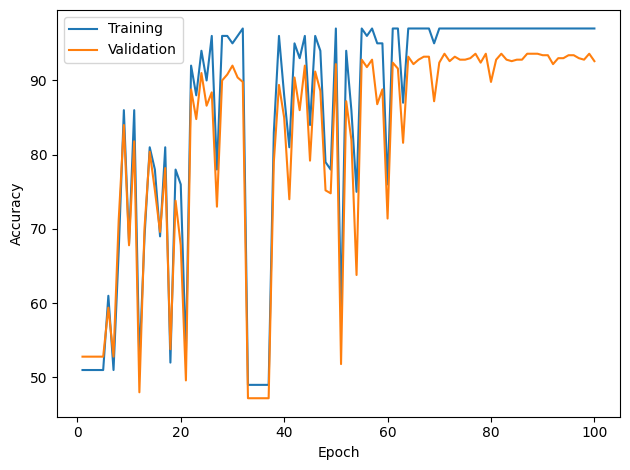

In [ ]:
plot_accuracy(train_acc_list=train_acc_list, valid_acc_list=valid_acc_list)

# **Model with Data Augmentation (Random Rotation and Random Cropping Transformations)**

In [ ]:
# 2. Define new transformation with data augmentation
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomCrop((16, 16)),
    transforms.RandomRotation(degrees=30, interpolation=PIL.Image.BILINEAR),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Create train, val and test datasets
full_dataset = datasets.Caltech101(root='./data', download=True, transform=transform)
selected_classes = ['Faces', 'Faces_easy']
indices = [i for i, (img, label) in enumerate(full_dataset)
           if full_dataset.categories[label] in selected_classes]
subset = Subset(full_dataset, indices)
train_dataset, val_dataset, test_dataset = random_split(subset, [100, 500, 270])

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Files already downloaded and verified


In [ ]:
# Instantiate the model2
input_size = 16 * 16 * 1  # Input size of the images
num_classes = 2  # Number of classes
model2 = LogisticRegression(input_size, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2.parameters(), lr=0.1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.to(device)

LogisticRegression(
  (fc1): Linear(in_features=256, out_features=15, bias=True)
  (fc2): Linear(in_features=15, out_features=45, bias=True)
  (fc3): Linear(in_features=45, out_features=2, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)

In [ ]:
start_time = time.time()
minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []

for epoch in range(SETTINGS['num epochs']):
    model2.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.to(device)
        targets = targets.to(device)

        # Forward pass
        logits = model2(features)
        loss = F.cross_entropy(logits, targets)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        minibatch_loss_list.append(loss.item())
        if batch_idx % 50 == 0:
            print(f'Epoch: {epoch+1:03d}/{SETTINGS["num epochs"]:03d} '
                  f'| Batch {batch_idx:04d}/{len(train_loader):04d} '
                  f'| Loss: {loss.item():.4f}')

    # Evaluate on training and validation sets
    model2.eval()
    with torch.no_grad():
        train_acc = compute_accuracy(model2, train_loader, device=device)
        valid_acc = compute_accuracy(model2, val_loader, device=device)
        print(f'Epoch: {epoch+1:03d}/{SETTINGS["num epochs"]:03d} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Validation Acc: {valid_acc:.2f}%')
        train_acc_list.append(float(train_acc))
        valid_acc_list.append(float(valid_acc))

    elapsed = (time.time() - start_time) / 60
    print(f'Time elapsed: {elapsed:.2f} min')

elapsed = (time.time() - start_time) / 60
print(f'Total Training Time: {elapsed:.2f} min')

# Evaluate on the test set
test_acc = compute_accuracy(model2, test_loader, device=device)
print(f'Test Accuracy: {test_acc:.2f}%')


Epoch: 001/100 | Batch 0000/0007 | Loss: 0.6858
Epoch: 001/100 | Train Acc: 52.00% | Validation Acc: 48.60%
Time elapsed: 0.02 min
Epoch: 002/100 | Batch 0000/0007 | Loss: 0.6933
Epoch: 002/100 | Train Acc: 52.00% | Validation Acc: 48.60%
Time elapsed: 0.04 min
Epoch: 003/100 | Batch 0000/0007 | Loss: 0.6978
Epoch: 003/100 | Train Acc: 53.00% | Validation Acc: 49.40%
Time elapsed: 0.06 min
Epoch: 004/100 | Batch 0000/0007 | Loss: 0.6940
Epoch: 004/100 | Train Acc: 56.00% | Validation Acc: 51.00%
Time elapsed: 0.08 min
Epoch: 005/100 | Batch 0000/0007 | Loss: 0.6913
Epoch: 005/100 | Train Acc: 65.00% | Validation Acc: 54.80%
Time elapsed: 0.10 min
Epoch: 006/100 | Batch 0000/0007 | Loss: 0.6925
Epoch: 006/100 | Train Acc: 52.00% | Validation Acc: 48.60%
Time elapsed: 0.12 min
Epoch: 007/100 | Batch 0000/0007 | Loss: 0.6901
Epoch: 007/100 | Train Acc: 52.00% | Validation Acc: 48.60%
Time elapsed: 0.14 min
Epoch: 008/100 | Batch 0000/0007 | Loss: 0.6913
Epoch: 008/100 | Train Acc: 52.00% 

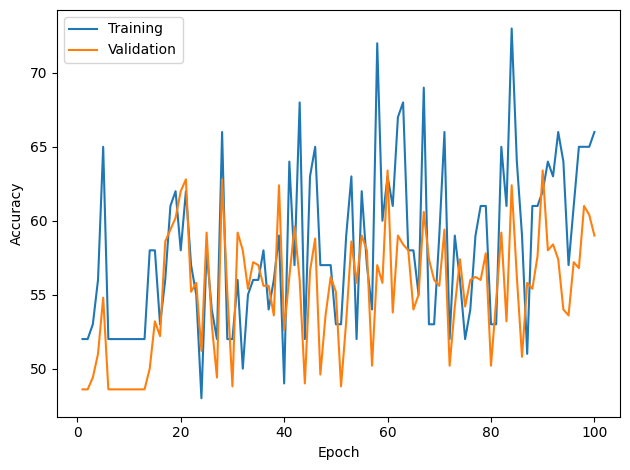

In [ ]:
plot_accuracy(train_acc_list=train_acc_list, valid_acc_list=valid_acc_list)

# **Model with L2 Regularization and No Data Augmentation**

In [ ]:
# Define transformation: resize, grayscale, and tensor conversion.
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Create train, val and test datasets
full_dataset = datasets.Caltech101(root='./data', download=True, transform=transform)

# we are going to use only these two classes
selected_classes = ['Faces', 'Faces_easy']
indices = [i for i, (img, label) in enumerate(full_dataset) if full_dataset.categories[label] in selected_classes]
subset = Subset(full_dataset, indices)
train_dataset, val_dataset, test_dataset = random_split(subset, [100, 500, 270])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Files already downloaded and verified


In [ ]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.fc1 = nn.Linear(input_size, 15)
        self.fc2 = nn.Linear(15, 45)
        self.fc3 = nn.Linear(45, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

In [ ]:
# Instantiate the model
input_size = 32 * 32 * 1  # Input size of the images
num_classes = 2  # Number of classes
model = LogisticRegression(input_size, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=SETTINGS["lambda"]) #L2 regularization

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LogisticRegression(
  (fc1): Linear(in_features=1024, out_features=15, bias=True)
  (fc2): Linear(in_features=15, out_features=45, bias=True)
  (fc3): Linear(in_features=45, out_features=2, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)

In [ ]:
start_time = time.time()
minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []

for epoch in range(SETTINGS['num epochs']):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.to(device)
        targets = targets.to(device)

        # Forward pass
        logits = model(features)
        loss = F.cross_entropy(logits, targets)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        minibatch_loss_list.append(loss.item())
        if batch_idx % 50 == 0:
            print(f'Epoch: {epoch+1:03d}/{SETTINGS["num epochs"]:03d} '
                  f'| Batch {batch_idx:04d}/{len(train_loader):04d} '
                  f'| Loss: {loss.item():.4f}')

    # Evaluate on training and validation sets
    model.eval()
    with torch.no_grad():
        train_acc = compute_accuracy(model, train_loader, device=device)
        valid_acc = compute_accuracy(model, val_loader, device=device)
        print(f'Epoch: {epoch+1:03d}/{SETTINGS["num epochs"]:03d} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Validation Acc: {valid_acc:.2f}%')
        train_acc_list.append(float(train_acc))
        valid_acc_list.append(float(valid_acc))

    elapsed = (time.time() - start_time) / 60
    print(f'Time elapsed: {elapsed:.2f} min')

elapsed = (time.time() - start_time) / 60
print(f'Total Training Time: {elapsed:.2f} min')

# Evaluate on the test set
test_acc = compute_accuracy(model, test_loader, device=device)
print(f'Test Accuracy: {test_acc:.2f}%')


Epoch: 001/100 | Batch 0000/0007 | Loss: 0.7129
Epoch: 001/100 | Train Acc: 55.00% | Validation Acc: 48.60%
Time elapsed: 0.02 min
Epoch: 002/100 | Batch 0000/0007 | Loss: 0.6931
Epoch: 002/100 | Train Acc: 49.00% | Validation Acc: 47.20%
Time elapsed: 0.04 min
Epoch: 003/100 | Batch 0000/0007 | Loss: 0.6895
Epoch: 003/100 | Train Acc: 51.00% | Validation Acc: 53.80%
Time elapsed: 0.06 min
Epoch: 004/100 | Batch 0000/0007 | Loss: 0.6803
Epoch: 004/100 | Train Acc: 64.00% | Validation Acc: 64.80%
Time elapsed: 0.07 min
Epoch: 005/100 | Batch 0000/0007 | Loss: 0.6935
Epoch: 005/100 | Train Acc: 68.00% | Validation Acc: 59.20%
Time elapsed: 0.09 min
Epoch: 006/100 | Batch 0000/0007 | Loss: 0.6835
Epoch: 006/100 | Train Acc: 51.00% | Validation Acc: 52.80%
Time elapsed: 0.12 min
Epoch: 007/100 | Batch 0000/0007 | Loss: 0.6749
Epoch: 007/100 | Train Acc: 51.00% | Validation Acc: 52.80%
Time elapsed: 0.14 min
Epoch: 008/100 | Batch 0000/0007 | Loss: 0.6589
Epoch: 008/100 | Train Acc: 58.00% 

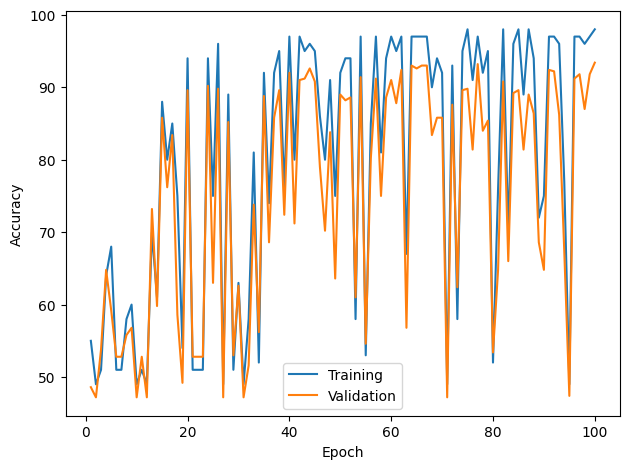

In [ ]:
plot_accuracy(train_acc_list, valid_acc_list)
plt.show()

# **Model with Dropout of 20% in hidden layer H1 and 60% in the hidden layer H2**

In [ ]:
# Define transformation: resize, grayscale, and tensor conversion.
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Create train, val and test datasets
full_dataset = datasets.Caltech101(root='./data', download=True, transform=transform)

# we are going to use only these two classes
selected_classes = ['Faces', 'Faces_easy']
indices = [i for i, (img, label) in enumerate(full_dataset) if full_dataset.categories[label] in selected_classes]
subset = Subset(full_dataset, indices)
train_dataset, val_dataset, test_dataset = random_split(subset, [100, 500, 270])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Files already downloaded and verified


In [ ]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.fc1 = nn.Linear(input_size, 15)
        self.dropout1 = nn.Dropout(p=0.20) # Drop 20% in hidden layer H1
        self.fc2 = nn.Linear(15, 45)
        self.dropout2 = nn.Dropout(p=0.60) # Drop 60% in the hidden layer H2
        self.fc3 = nn.Linear(45, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.softmax(self.fc3(x))
        return x

In [ ]:
# Instantiate the model
input_size = 32 * 32 * 1  # Input size of the images
num_classes = 2  # Number of classes
model = LogisticRegression(input_size, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LogisticRegression(
  (fc1): Linear(in_features=1024, out_features=15, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=15, out_features=45, bias=True)
  (dropout2): Dropout(p=0.6, inplace=False)
  (fc3): Linear(in_features=45, out_features=2, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)

In [ ]:
start_time = time.time()
minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []

for epoch in range(SETTINGS['num epochs']):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.to(device)
        targets = targets.to(device)

        # Forward pass
        logits = model(features)
        loss = F.cross_entropy(logits, targets)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        minibatch_loss_list.append(loss.item())
        if batch_idx % 50 == 0:
            print(f'Epoch: {epoch+1:03d}/{SETTINGS["num epochs"]:03d} '
                  f'| Batch {batch_idx:04d}/{len(train_loader):04d} '
                  f'| Loss: {loss.item():.4f}')

    # Evaluate on training and validation sets
    model.eval()
    with torch.no_grad():
        train_acc = compute_accuracy(model, train_loader, device=device)
        valid_acc = compute_accuracy(model, val_loader, device=device)
        print(f'Epoch: {epoch+1:03d}/{SETTINGS["num epochs"]:03d} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Validation Acc: {valid_acc:.2f}%')
        train_acc_list.append(float(train_acc))
        valid_acc_list.append(float(valid_acc))

    elapsed = (time.time() - start_time) / 60
    print(f'Time elapsed: {elapsed:.2f} min')

elapsed = (time.time() - start_time) / 60
print(f'Total Training Time: {elapsed:.2f} min')

# Evaluate on the test set
test_acc = compute_accuracy(model, test_loader, device=device)
print(f'Test Accuracy: {test_acc:.2f}%')


Epoch: 001/100 | Batch 0000/0007 | Loss: 0.6863
Epoch: 001/100 | Train Acc: 60.00% | Validation Acc: 47.40%
Time elapsed: 0.02 min
Epoch: 002/100 | Batch 0000/0007 | Loss: 0.6769
Epoch: 002/100 | Train Acc: 60.00% | Validation Acc: 47.40%
Time elapsed: 0.04 min
Epoch: 003/100 | Batch 0000/0007 | Loss: 0.6725
Epoch: 003/100 | Train Acc: 60.00% | Validation Acc: 47.40%
Time elapsed: 0.07 min
Epoch: 004/100 | Batch 0000/0007 | Loss: 0.6941
Epoch: 004/100 | Train Acc: 60.00% | Validation Acc: 47.40%
Time elapsed: 0.09 min
Epoch: 005/100 | Batch 0000/0007 | Loss: 0.6641
Epoch: 005/100 | Train Acc: 60.00% | Validation Acc: 47.40%
Time elapsed: 0.10 min
Epoch: 006/100 | Batch 0000/0007 | Loss: 0.6989
Epoch: 006/100 | Train Acc: 60.00% | Validation Acc: 47.40%
Time elapsed: 0.12 min
Epoch: 007/100 | Batch 0000/0007 | Loss: 0.6311
Epoch: 007/100 | Train Acc: 60.00% | Validation Acc: 47.40%
Time elapsed: 0.14 min
Epoch: 008/100 | Batch 0000/0007 | Loss: 0.6562
Epoch: 008/100 | Train Acc: 60.00% 

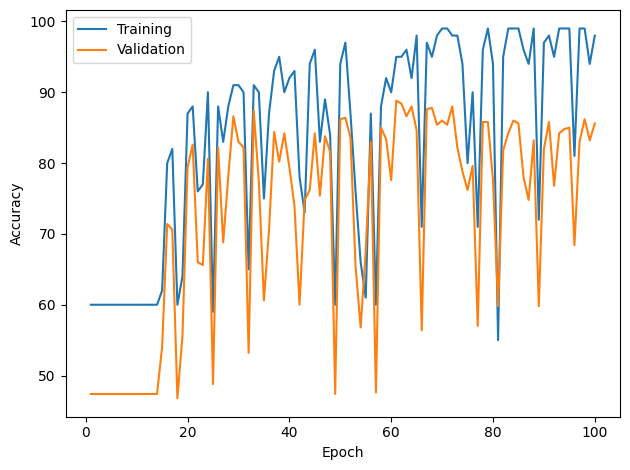

In [ ]:
plot_accuracy(train_acc_list, valid_acc_list)